In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import copy
import math
import os

In [2]:
TestImagePos = r'E:\GithubProjects\KagglePractice\FaceDetection\Dataset\1 (1).jpg'

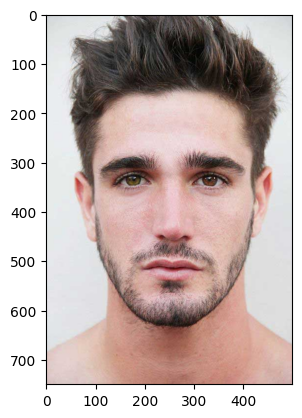

In [3]:
TestImage = cv.imread(TestImagePos)

plt.imshow(cv.cvtColor(TestImage, cv.COLOR_BGR2RGB))
plt.show()

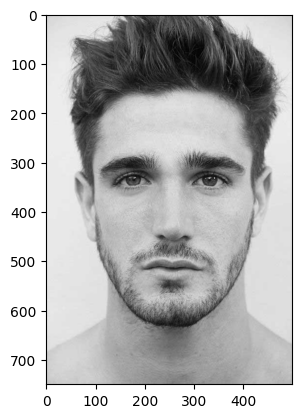

In [4]:
GrayTestImage = cv.cvtColor(TestImage, cv.COLOR_BGR2GRAY)

plt.imshow(cv.cvtColor(GrayTestImage, cv.COLOR_BGR2RGB))
plt.show()

In [5]:
GrayTestImage.shape

(750, 500)

In [6]:
np.unique(GrayTestImage)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [7]:
VectorDict = {
	(0, 0) : 0,
	(0, 1) : 1,
	(1, 1) : 2,
	(1, 0) : 3,
	(1, -1) : 4,
	(0, -1) : 5,
	(-1, -1) : 6,
	(-1, 0) : 7,
	(-1, 1) : 8,
}

def GetGoodVector2(Image : np.ndarray, PosX : int, PosY : int, CheckWidth : int = 11):
	BestPos = (0, 0)
	BestValue = -99999
	CurrentGray = Image[PosY][PosX]
	try:
		SlicedImage = Image[PosY:PosY + CheckWidth, PosX : PosX + CheckWidth]
		BestValue = SlicedImage.max()
		# print(np.where(SlicedImage == BestValue), SlicedImage)
		VectorX, VectorY = np.where(SlicedImage == BestValue)
		BestPos = (VectorX[0] - int((CheckWidth-1)/2), VectorY[0] - int((CheckWidth-1)/2))
	except:
		pass
	# for y in range(-1,2):
	# 	for x in range(-1,2):
	# 		if x != 0 and y != 0:
	# 			try:
	# 				if BestValue < Image[PosY + y][PosX + x] - CurrentGray:
	# 					BestValue = Image[PosY + y][PosX + x] - CurrentGray
	# 					BestPos = VectorDict[(x, y)]
	# 			except:
	# 				pass
	BestPos = (1 if BestPos[0] > 0 else 0 if BestPos[0] == 0 else -1,
			   1 if BestPos[1] > 0 else 0 if BestPos[1] == 0 else -1)
	return VectorDict[BestPos]

def ConvertVector2(Image : np.ndarray, CheckWidth : int = 11):
	Copy = copy.deepcopy(Image)
	Height , Width = Image.shape
	print(Width , Height)
	for y in range(Height):
		for x in range(Width):
			Copy[y][x] = GetGoodVector2(Copy, x, y, CheckWidth)
	return Copy

In [8]:
ConvertedImage = ConvertVector2(GrayTestImage)

500 750


In [9]:
VectorDictSwap = dict([(value, key) for key, value in VectorDict.items()])

def ConvertedToShow(Image : np.ndarray, ImageSliceSize : int = 10, isReturn : bool = False):
	Copy = copy.deepcopy(Image)
	Height , Width = Image.shape
	print(Width , Height)

	ShowImage = [[0]*Width for i in range(Height)]
	# AverageVectorList = []
	for BigY in range(int(Height / ImageSliceSize)):
		# AverageVectorListX = []
		for BigX in range(int(Width / ImageSliceSize)):
			AverageVector = (0, 0)
			for y in range(ImageSliceSize):
				for x in range(ImageSliceSize):
					PosX, PosY = BigX * ImageSliceSize + x, BigY * ImageSliceSize + y
					CurrentVector = VectorDictSwap.get(Copy[PosY][PosX])
					AverageVector = (AverageVector[0] + CurrentVector[0], AverageVector[1] + CurrentVector[1])
			AverageVector = (AverageVector[0] / (ImageSliceSize**2), AverageVector[1] / (ImageSliceSize**2))
			# AverageVector = (-1 if AverageVector[0] < 0 else 0 if AverageVector[0] == 0 else 1,
			# 				 -1 if AverageVector[1] < 0 else 0 if AverageVector[1] == 0 else 1)
			AverageVectorLength = math.sqrt(AverageVector[0]**2 + AverageVector[1]**2)
			if AverageVectorLength == 0:
				AverageVector = (0, 0)
			else:
				AverageVector = (AverageVector[0] / AverageVectorLength, AverageVector[1] / AverageVectorLength)

			OriginalVector = AverageVector
			OriginalVector = (OriginalVector[1], -OriginalVector[0])

			CurrentPos = (-OriginalVector[0] * ((ImageSliceSize-1) / 2), -OriginalVector[1] * ((ImageSliceSize-1) / 2))
			OriginalPos = (-OriginalVector[0] * ((ImageSliceSize-1) / 2), -OriginalVector[1] * ((ImageSliceSize-1) / 2))
			PossibleDict = {}
			# Line
			for i in range(ImageSliceSize):
				PossibleDict[CurrentPos] = True
				CurrentPos = (int(OriginalPos[0] + OriginalVector[0] * i), int(OriginalPos[1] + OriginalVector[1] * i))
				# print(BigX, CurrentPos)

			# Fill
			for y in range(ImageSliceSize):
				for x in range(ImageSliceSize):
					# ShowImage[BigY][BigX]
					# AverageVector = AverageVectorList[BigY][BigX]
					if PossibleDict.get((int(OriginalPos[0] + x), int(OriginalPos[0] + y))) == None:
						ShowImage[BigY * ImageSliceSize + y][BigX * ImageSliceSize + x] = 0
					else:
						ShowImage[BigY * ImageSliceSize + y][BigX * ImageSliceSize + x] = 255
			# AverageVectorListX.append(AverageVector)
		# AverageVectorList.append(AverageVectorListX)
	# print(AverageVectorList)
	# for BigY in range(int(Height / ImageSliceSize)):
	# 	for BigX in range(int(Width / ImageSliceSize)):
			
	# 		OriginalVector = AverageVectorList[BigY][BigX]
	# 		OriginalVector = (OriginalVector[1], -OriginalVector[0])

	# 		CurrentPos = (-OriginalVector[0] * ((ImageSliceSize-1) / 2), -OriginalVector[1] * ((ImageSliceSize-1) / 2))
	# 		OriginalPos = (-OriginalVector[0] * ((ImageSliceSize-1) / 2), -OriginalVector[1] * ((ImageSliceSize-1) / 2))
	# 		PossibleDict = {}
	# 		# Line
	# 		for i in range(ImageSliceSize):
	# 			PossibleDict[CurrentPos] = True
	# 			CurrentPos = (int(OriginalPos[0] + OriginalVector[0] * i), int(OriginalPos[1] + OriginalVector[1] * i))
	# 			# print(BigX, CurrentPos)


	# 		# CurrentPos = (-OriginalVector[0] * int((ImageSliceSize-1) / 2), -OriginalVector[1] * int((ImageSliceSize-1) / 2))
	# 		# Arrow
	# 		# for _ in range(ImageSliceSize):
	# 		# 	PossibleDict[CurrentPos] = True
	# 		# 	CurrentPos = (CurrentPos[0] + OriginalVector[0], CurrentPos[1])
	# 		# CurrentPos = (-OriginalVector[0] * int((ImageSliceSize-1) / 2), -OriginalVector[1] * int((ImageSliceSize-1) / 2))
	# 		# for _ in range(ImageSliceSize):
	# 		# 	PossibleDict[CurrentPos] = True
	# 		# 	CurrentPos = (CurrentPos[0], CurrentPos[1] + OriginalVector[1])

	# 		# Fill
	# 		for y in range(ImageSliceSize):
	# 			for x in range(ImageSliceSize):
	# 				# ShowImage[BigY][BigX]
	# 				# AverageVector = AverageVectorList[BigY][BigX]
	# 				if PossibleDict.get((int(OriginalPos[0] + x), int(OriginalPos[0] + y))) == None:
	# 					ShowImage[BigY * ImageSliceSize + y][BigX * ImageSliceSize + x] = 0
	# 				else:
	# 					ShowImage[BigY * ImageSliceSize + y][BigX * ImageSliceSize + x] = 255
	ShowImage = np.array(ShowImage)
	if isReturn:
		return ShowImage
	else:
		plt.imshow(ShowImage)
		plt.show()

500 750


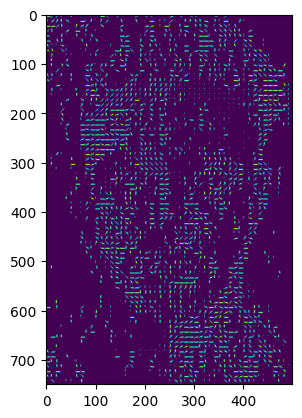

In [10]:
ConvertedToShow(ConvertedImage, 10)

In [11]:
def ShowGradientImage(ImagePos, SliceSize:int=10, ResizeHeight : int = -1, CheckWidth : int = 11, isReturn : bool = False):
	Image = cv.imread(ImagePos)
	OriginalHeight, OriginalWidth = Image.shape[0], Image.shape[1]
	Gray = cv.cvtColor(Image, cv.COLOR_BGR2GRAY)
	if ResizeHeight > 0:
		# Width : Height = ? , ResizeHeight
		# ? = ResizeHeight * Width / Height
		Height = ResizeHeight
		Width = int(ResizeHeight * OriginalWidth / OriginalHeight)
		New = [[0] * Width for _ in range(Height)]
		for y in range(Height):
			for x in range(Width):
				New[y][x] = Gray[int(y * OriginalHeight / Height)][int(x * OriginalWidth / Width)]
		# Image = Image[0:Width:OriginalWidth/Width,0:Height:OriginalHeight/Height]

		Gray = ConvertVector2(np.array(New), CheckWidth)
	else:
		Gray = ConvertVector2(Gray, CheckWidth)
	if isReturn:
		return ConvertedToShow(Gray, SliceSize, isReturn=True)
	else:
		ConvertedToShow(Gray, SliceSize)

1066 1600
1066 1600


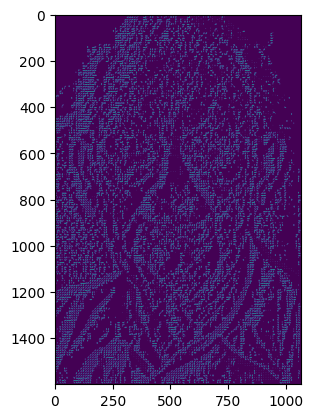

In [12]:
ShowGradientImage(r'E:\GithubProjects\KagglePractice\FaceDetection\Dataset\1 (1).jpeg')

In [13]:
TopPos = r'E:\GithubProjects\KagglePractice\FaceDetection\Dataset'

1066 1600
1066 1600


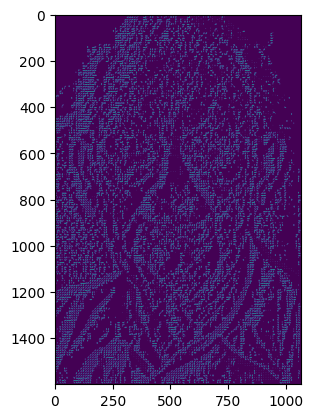

In [14]:
ShowGradientImage(fr'{TopPos}\{os.listdir(TopPos)[0]}')

960 1280
960 1280


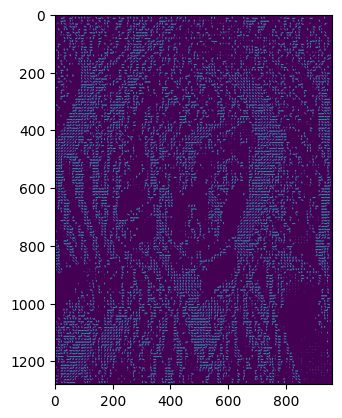

In [15]:
ShowGradientImage(fr'{TopPos}\{os.listdir(TopPos)[3]}')

600 757
600 757


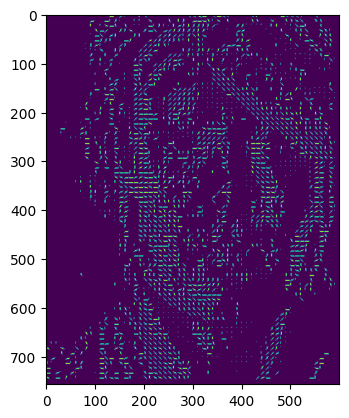

In [16]:
ShowGradientImage(fr'{TopPos}\{os.listdir(TopPos)[105]}')

644 900
644 900


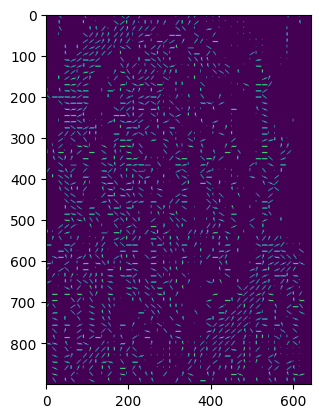

In [17]:
ShowGradientImage(fr'{TopPos}\{os.listdir(TopPos)[205]}', 15)

560 700
560 700


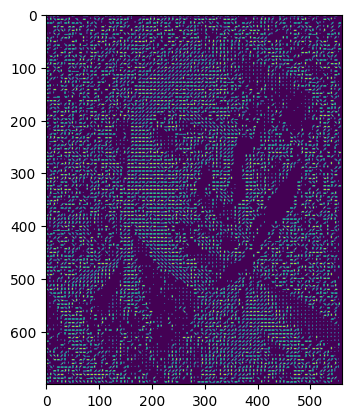

In [18]:
ShowGradientImage(fr'{TopPos}\{os.listdir(TopPos)[905]}', SliceSize=7, ResizeHeight=700, CheckWidth=4)

560 700
560 700


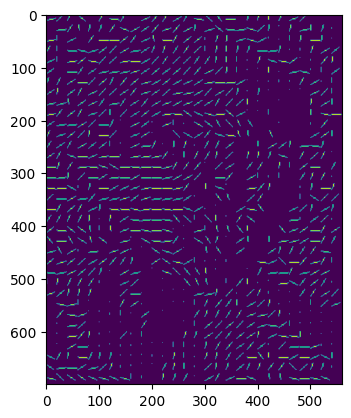

In [19]:
ShowGradientImage(fr'{TopPos}\{os.listdir(TopPos)[905]}', SliceSize=20, ResizeHeight=700, CheckWidth=4)

0 0
466 700
466 700
0 1
466 700
466 700


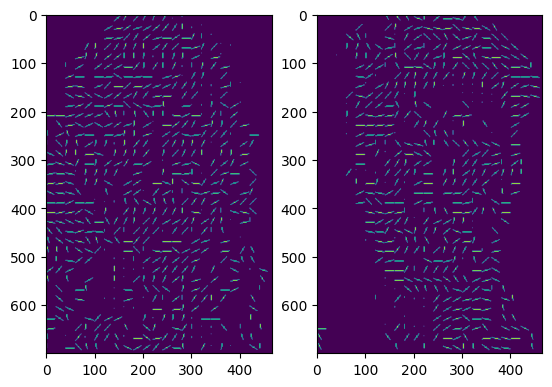

1 0
569 700
569 700
1 1
525 700
525 700


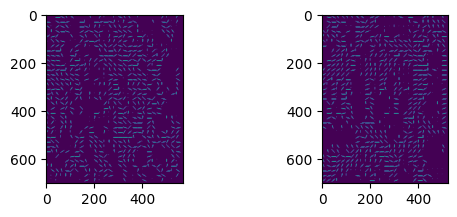

In [22]:
for y in range(2):
	for x in range(2):
		print(y,x)
		plt.subplot(y + 1, 2, x + 1)
		plt.imshow(ShowGradientImage(fr'{TopPos}\{os.listdir(TopPos)[y * 2 + x]}', SliceSize=20, ResizeHeight=700, CheckWidth=4, isReturn=True))
	plt.show()

여기서 더 어떻게 할 지 잘 모르겠다  
이제부터 라이브러리를 써봐야겠다